In [1]:
!pip install emoji
!pip install xgboost
!pip install tensorflow
!pip3 install wordcloud

## Import all libraries

In [1]:
import pandas as pd
import re, string
import emoji
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib as mpl

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_df = pd.read_csv('cyberbullying_tweets.csv')

In [3]:
data_df.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

## Data Preprocessing

In [4]:
data_df.cyberbullying_type.value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
data_df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [7]:
def strip_emoji(text):
    #return re.sub(emoji.get_emoji_regexp(), r"", text)
#def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are
    # matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

In [8]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

In [9]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

In [10]:
#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])
#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [11]:
#Then we apply all the defined functions in the following order
def preprocess(text):
    #text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [12]:
texts_cleaned = []
for t in data_df.tweet_text:
    texts_cleaned.append(preprocess(t))

In [13]:
data_df['text_clean'] = texts_cleaned

In [14]:
data_df.head()

tweet_text cyberbullying_type  \
0  In other words #katandandre, your food was cra...  not_cyberbullying   
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   

                                          text_clean  
0                 word katandandr food crapilici mkr  
1  aussietv white mkr theblock today sunris studi...  
2                     classi whore red velvet cupcak  
3  meh p thank head concern anoth angri dude twitter  
4  isi account pretend kurdish account like islam...

In [15]:
# from sklearn.feature_extraction.text import CountVectorizer 
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.pipeline import Pipeline


# tfidf = TfidfTransformer()
# clf = CountVectorizer()

# X_cv =  clf.fit_transform(data_df['text_clean'])

# tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
# X_tf = tf_transformer.transform(X_cv)

In [16]:
#X_tf

In [17]:
#


## Word cloud generation


In [18]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [19]:
religion_df = data_df[data_df['cyberbullying_type']=="religion"]
age_df=data_df[data_df['cyberbullying_type']=="age"]
gender_df=data_df[data_df['cyberbullying_type']=="gender"]
ethinicity_df=data_df[data_df['cyberbullying_type']=="ethinicity"]
not_cyber_df=data_df[data_df['cyberbullying_type']=="not_cyberbullying"]

In [20]:
#religion_text

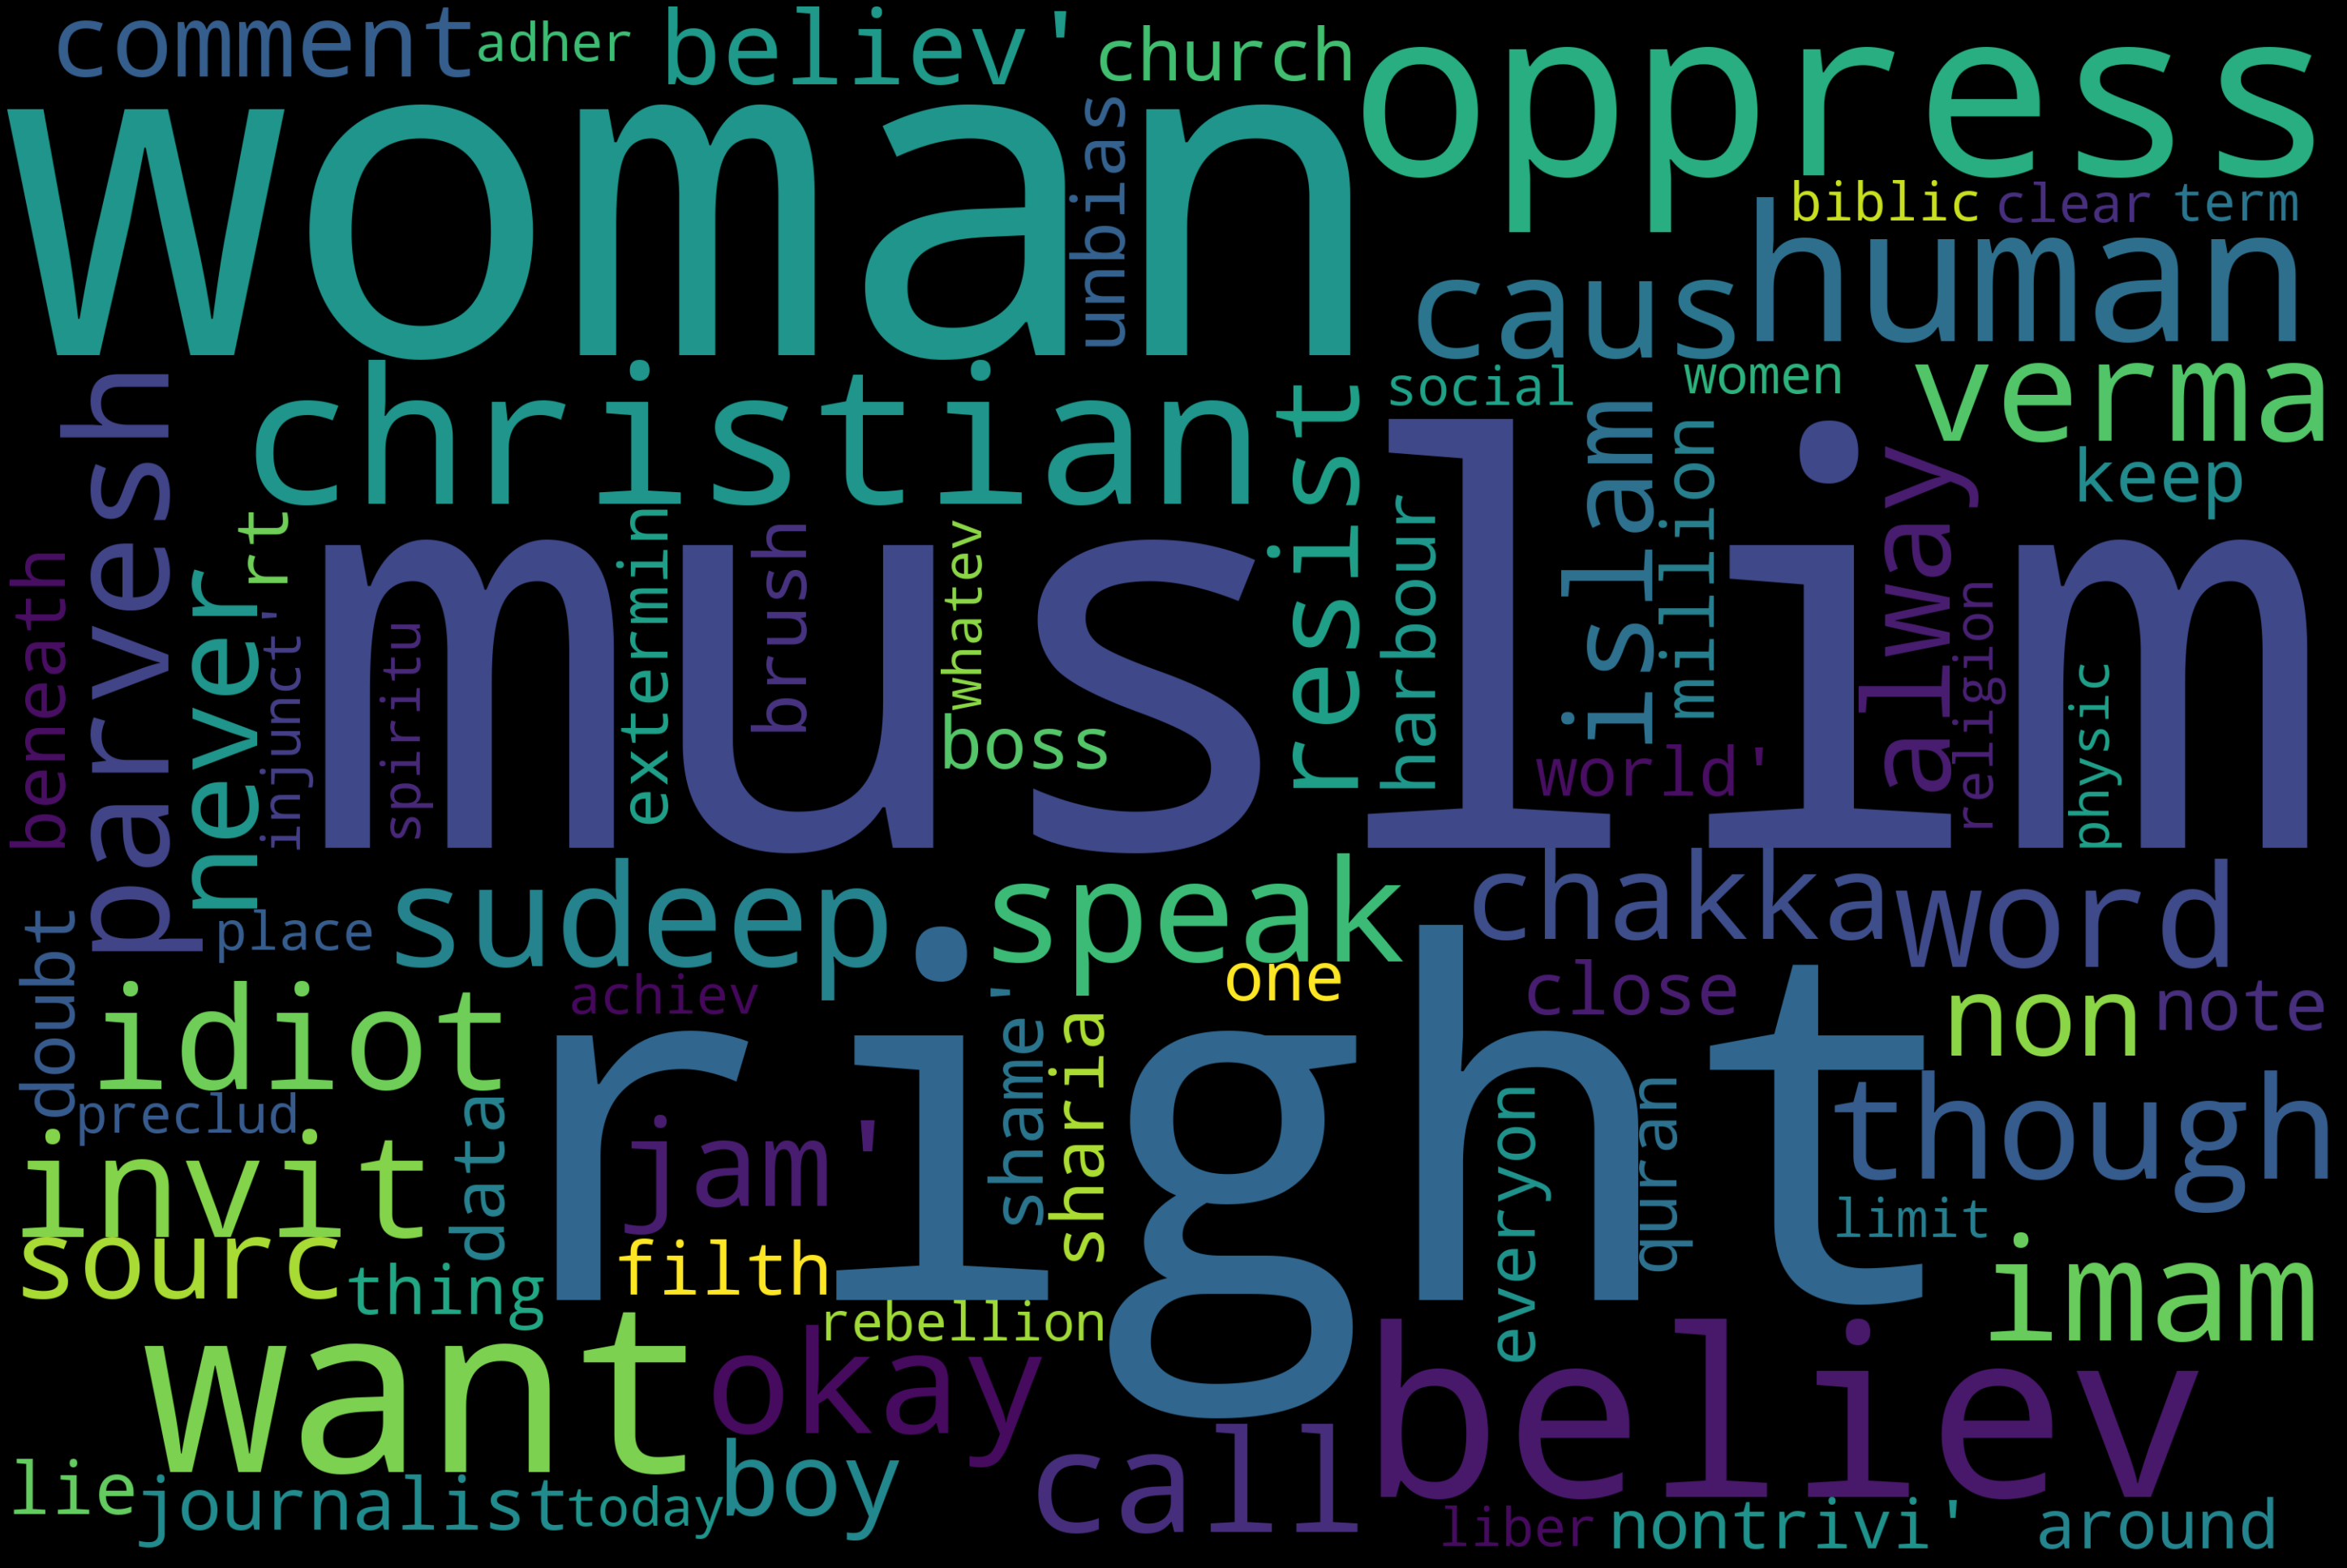

In [21]:
rel_txt=religion_df['text_clean']
generate_word_cloud(rel_txt.values)

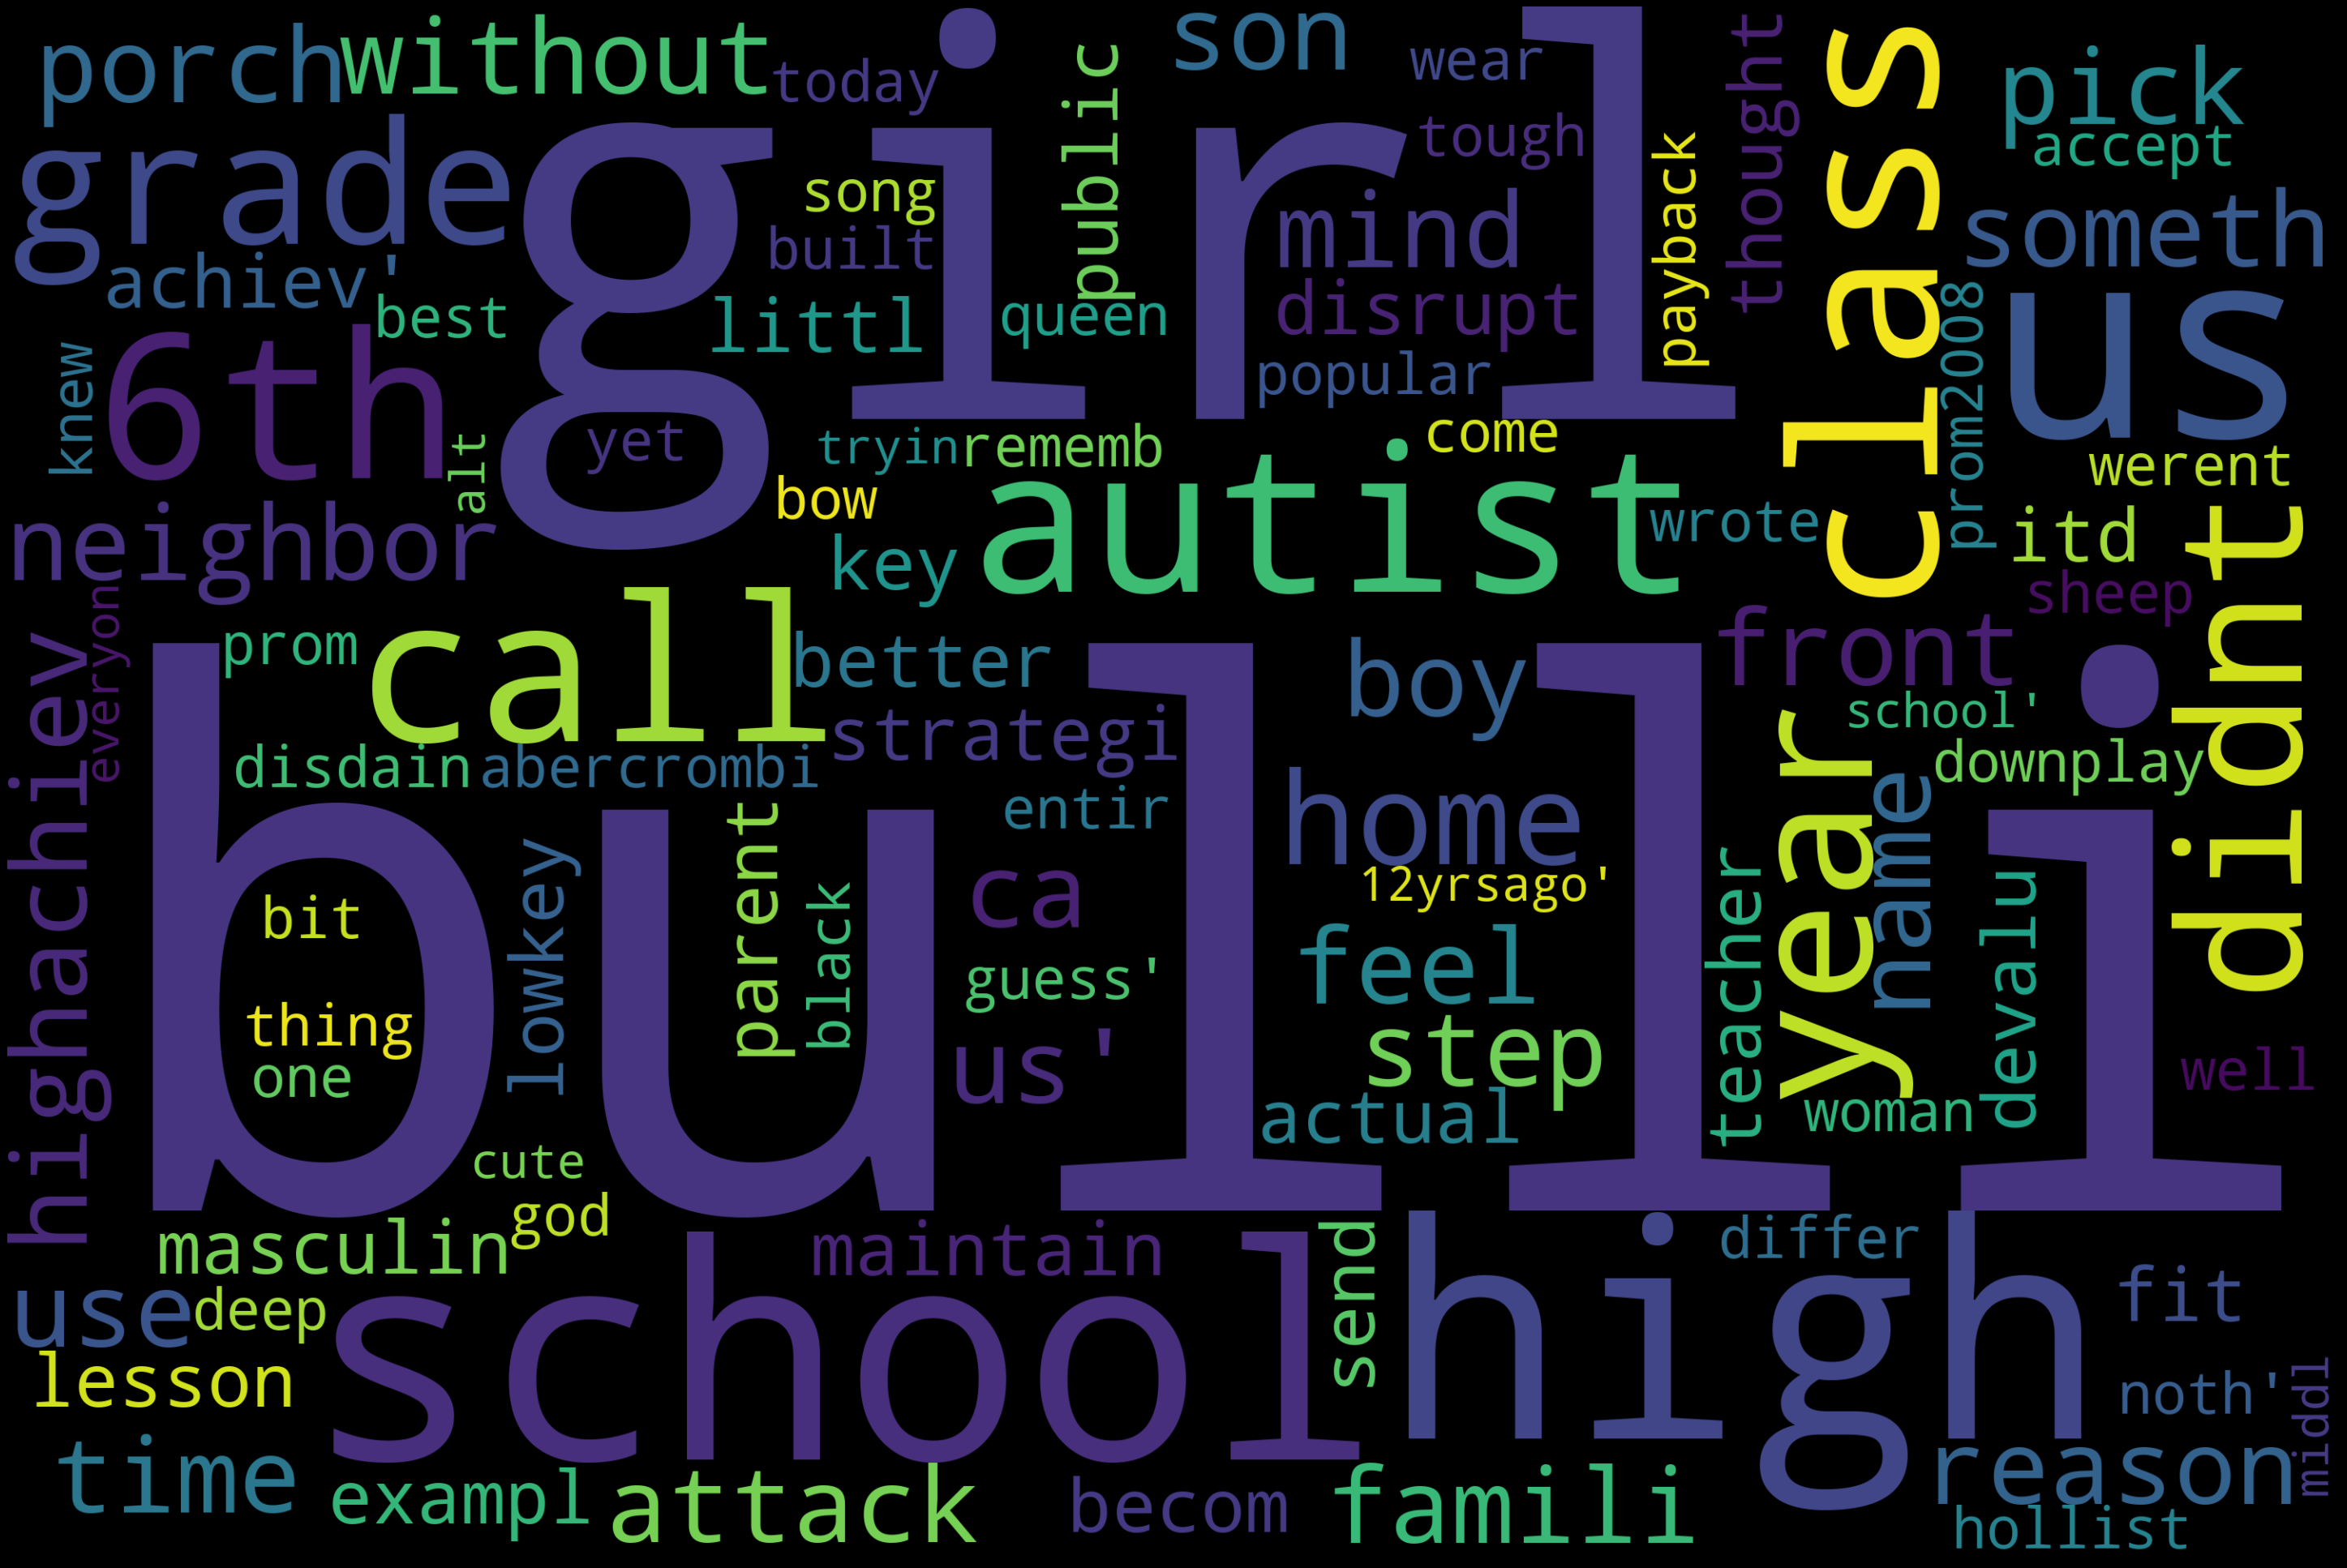

In [22]:
age_txt=age_df['text_clean']
generate_word_cloud(age_txt.values)
# age_df=data_df[data_df['cyberbullying_type']=="age"]
# gender_df=data_df[data_df['cyberbullying_type']=="gender"]
# ethinicity_df=data_df[data_df['cyberbullying_type']=="ethinicity"]
# not_cyber_df=data_df[data_df['cyberbullying_type']=="not_cyberbullying"]

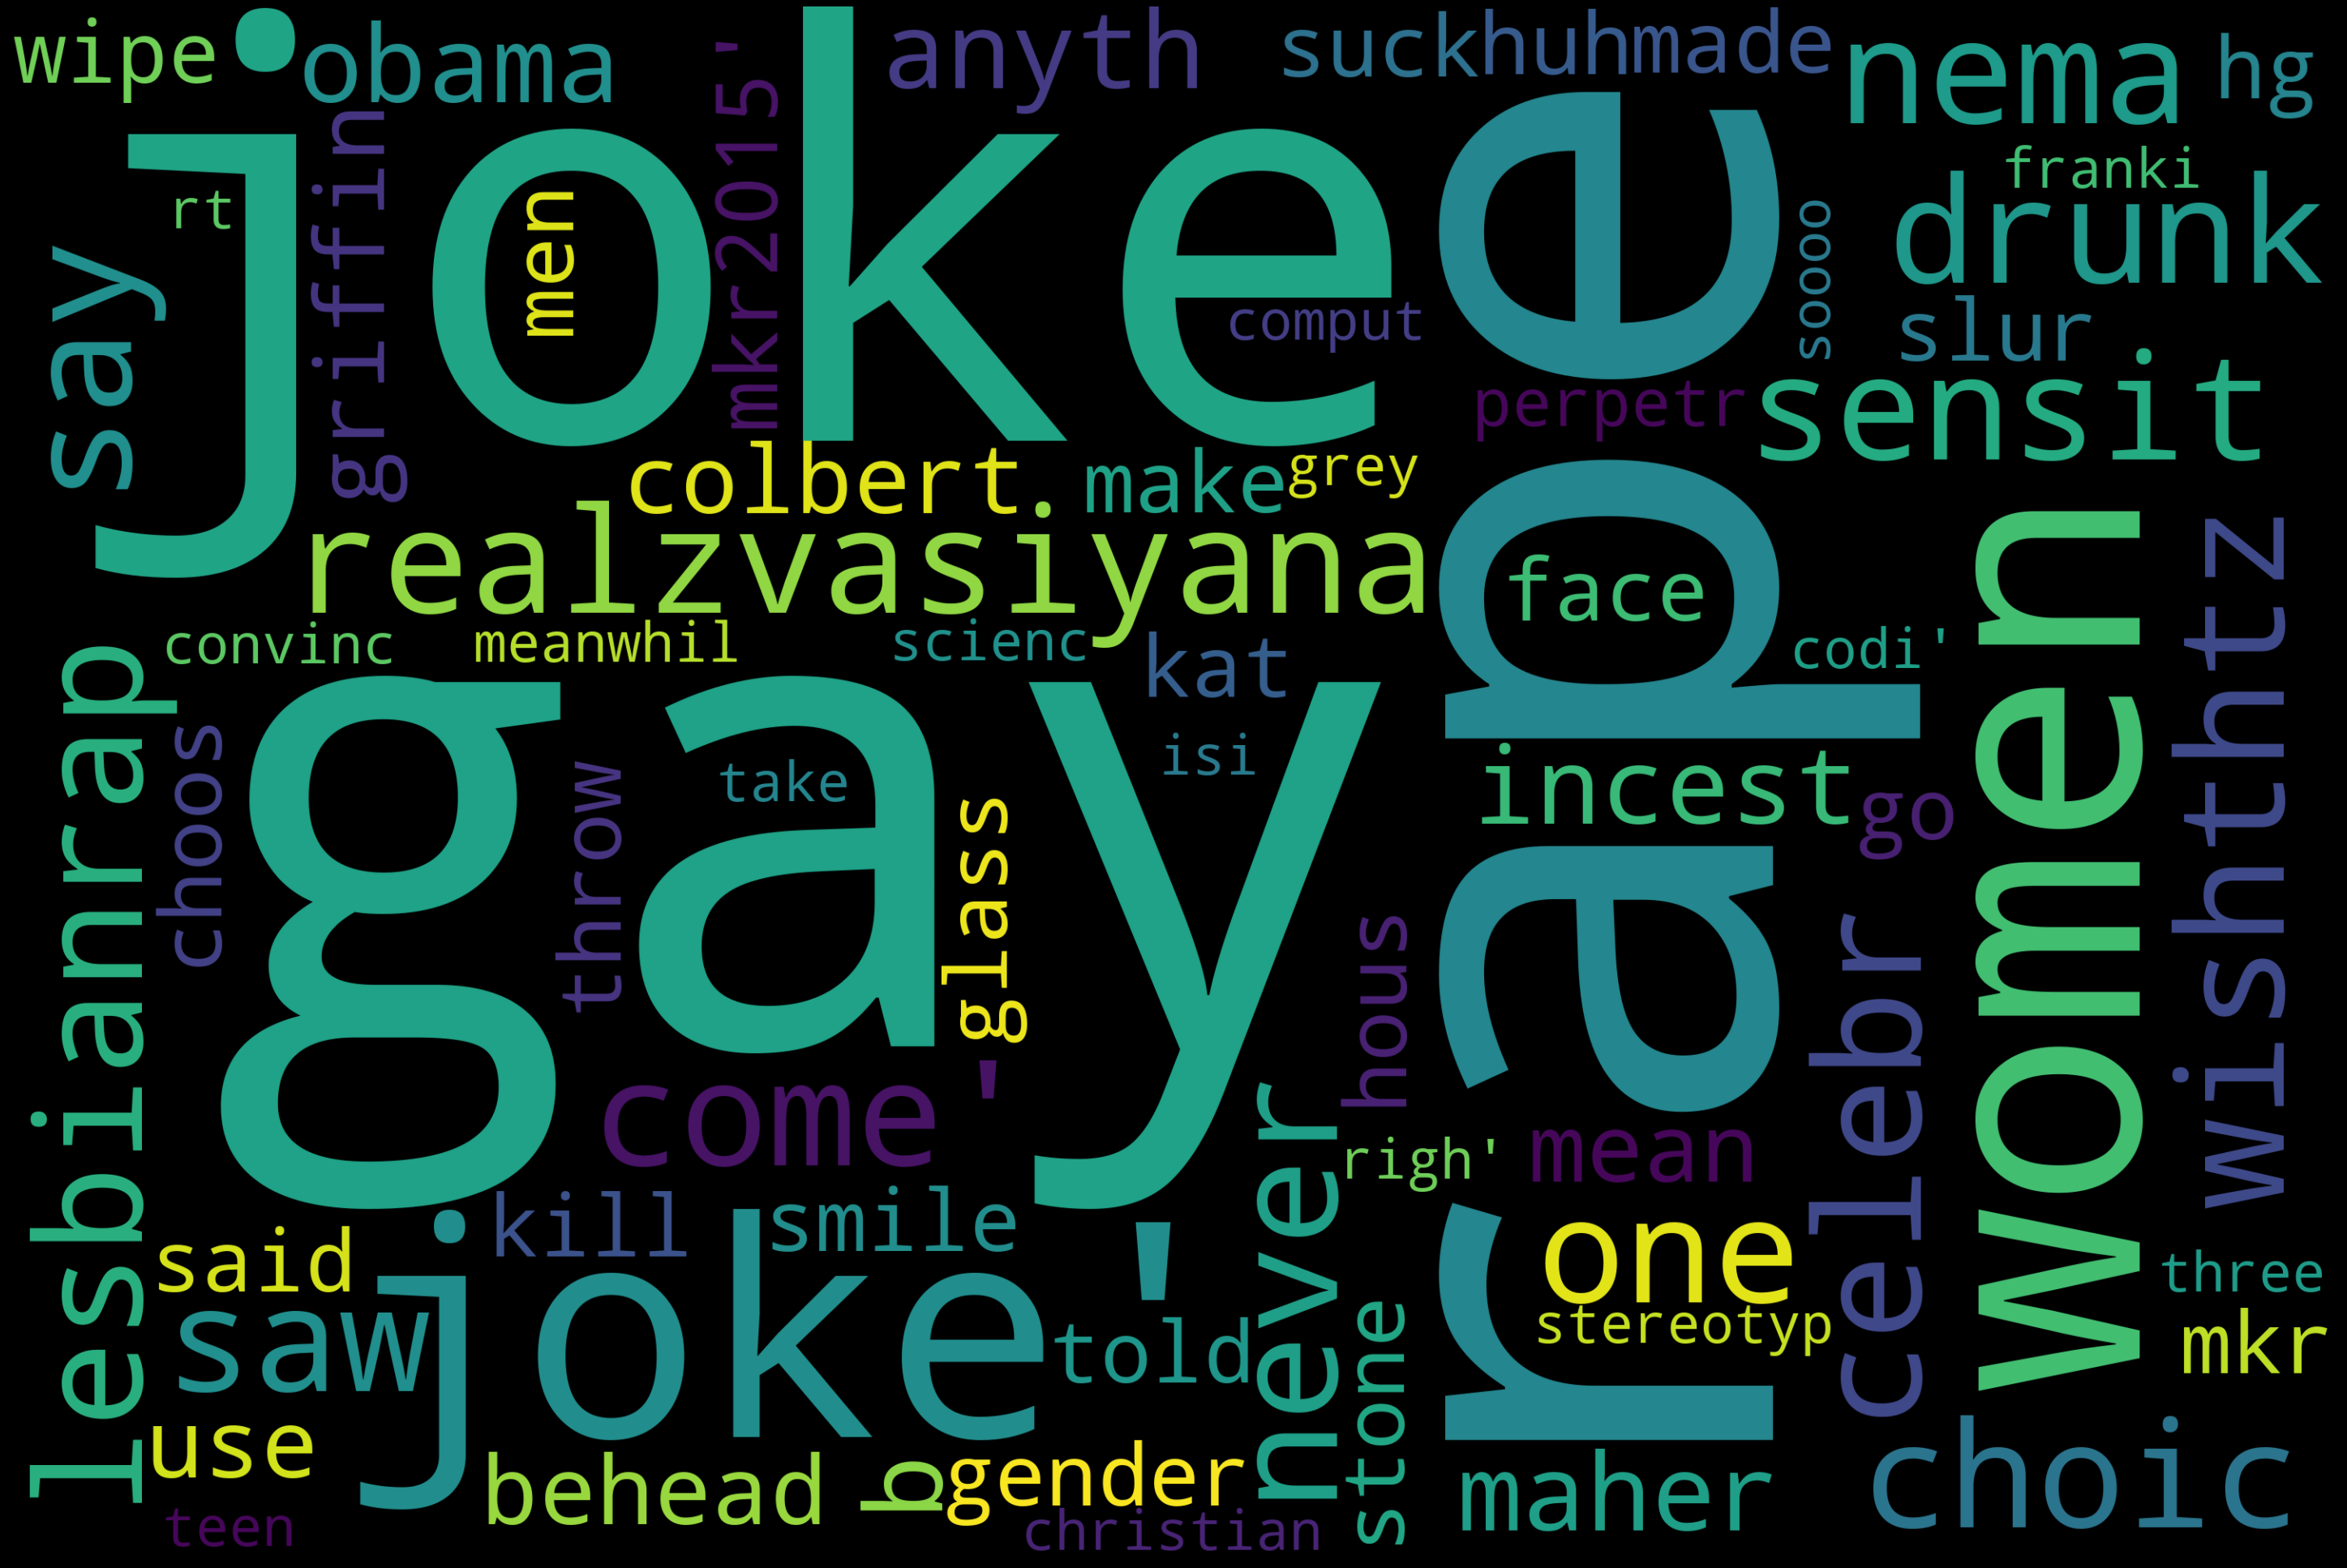

In [23]:
gender_txt=gender_df['text_clean']
generate_word_cloud(gender_txt.values)

In [24]:
ethnicity_df=data_df[data_df['cyberbullying_type']=="ethnicity"]

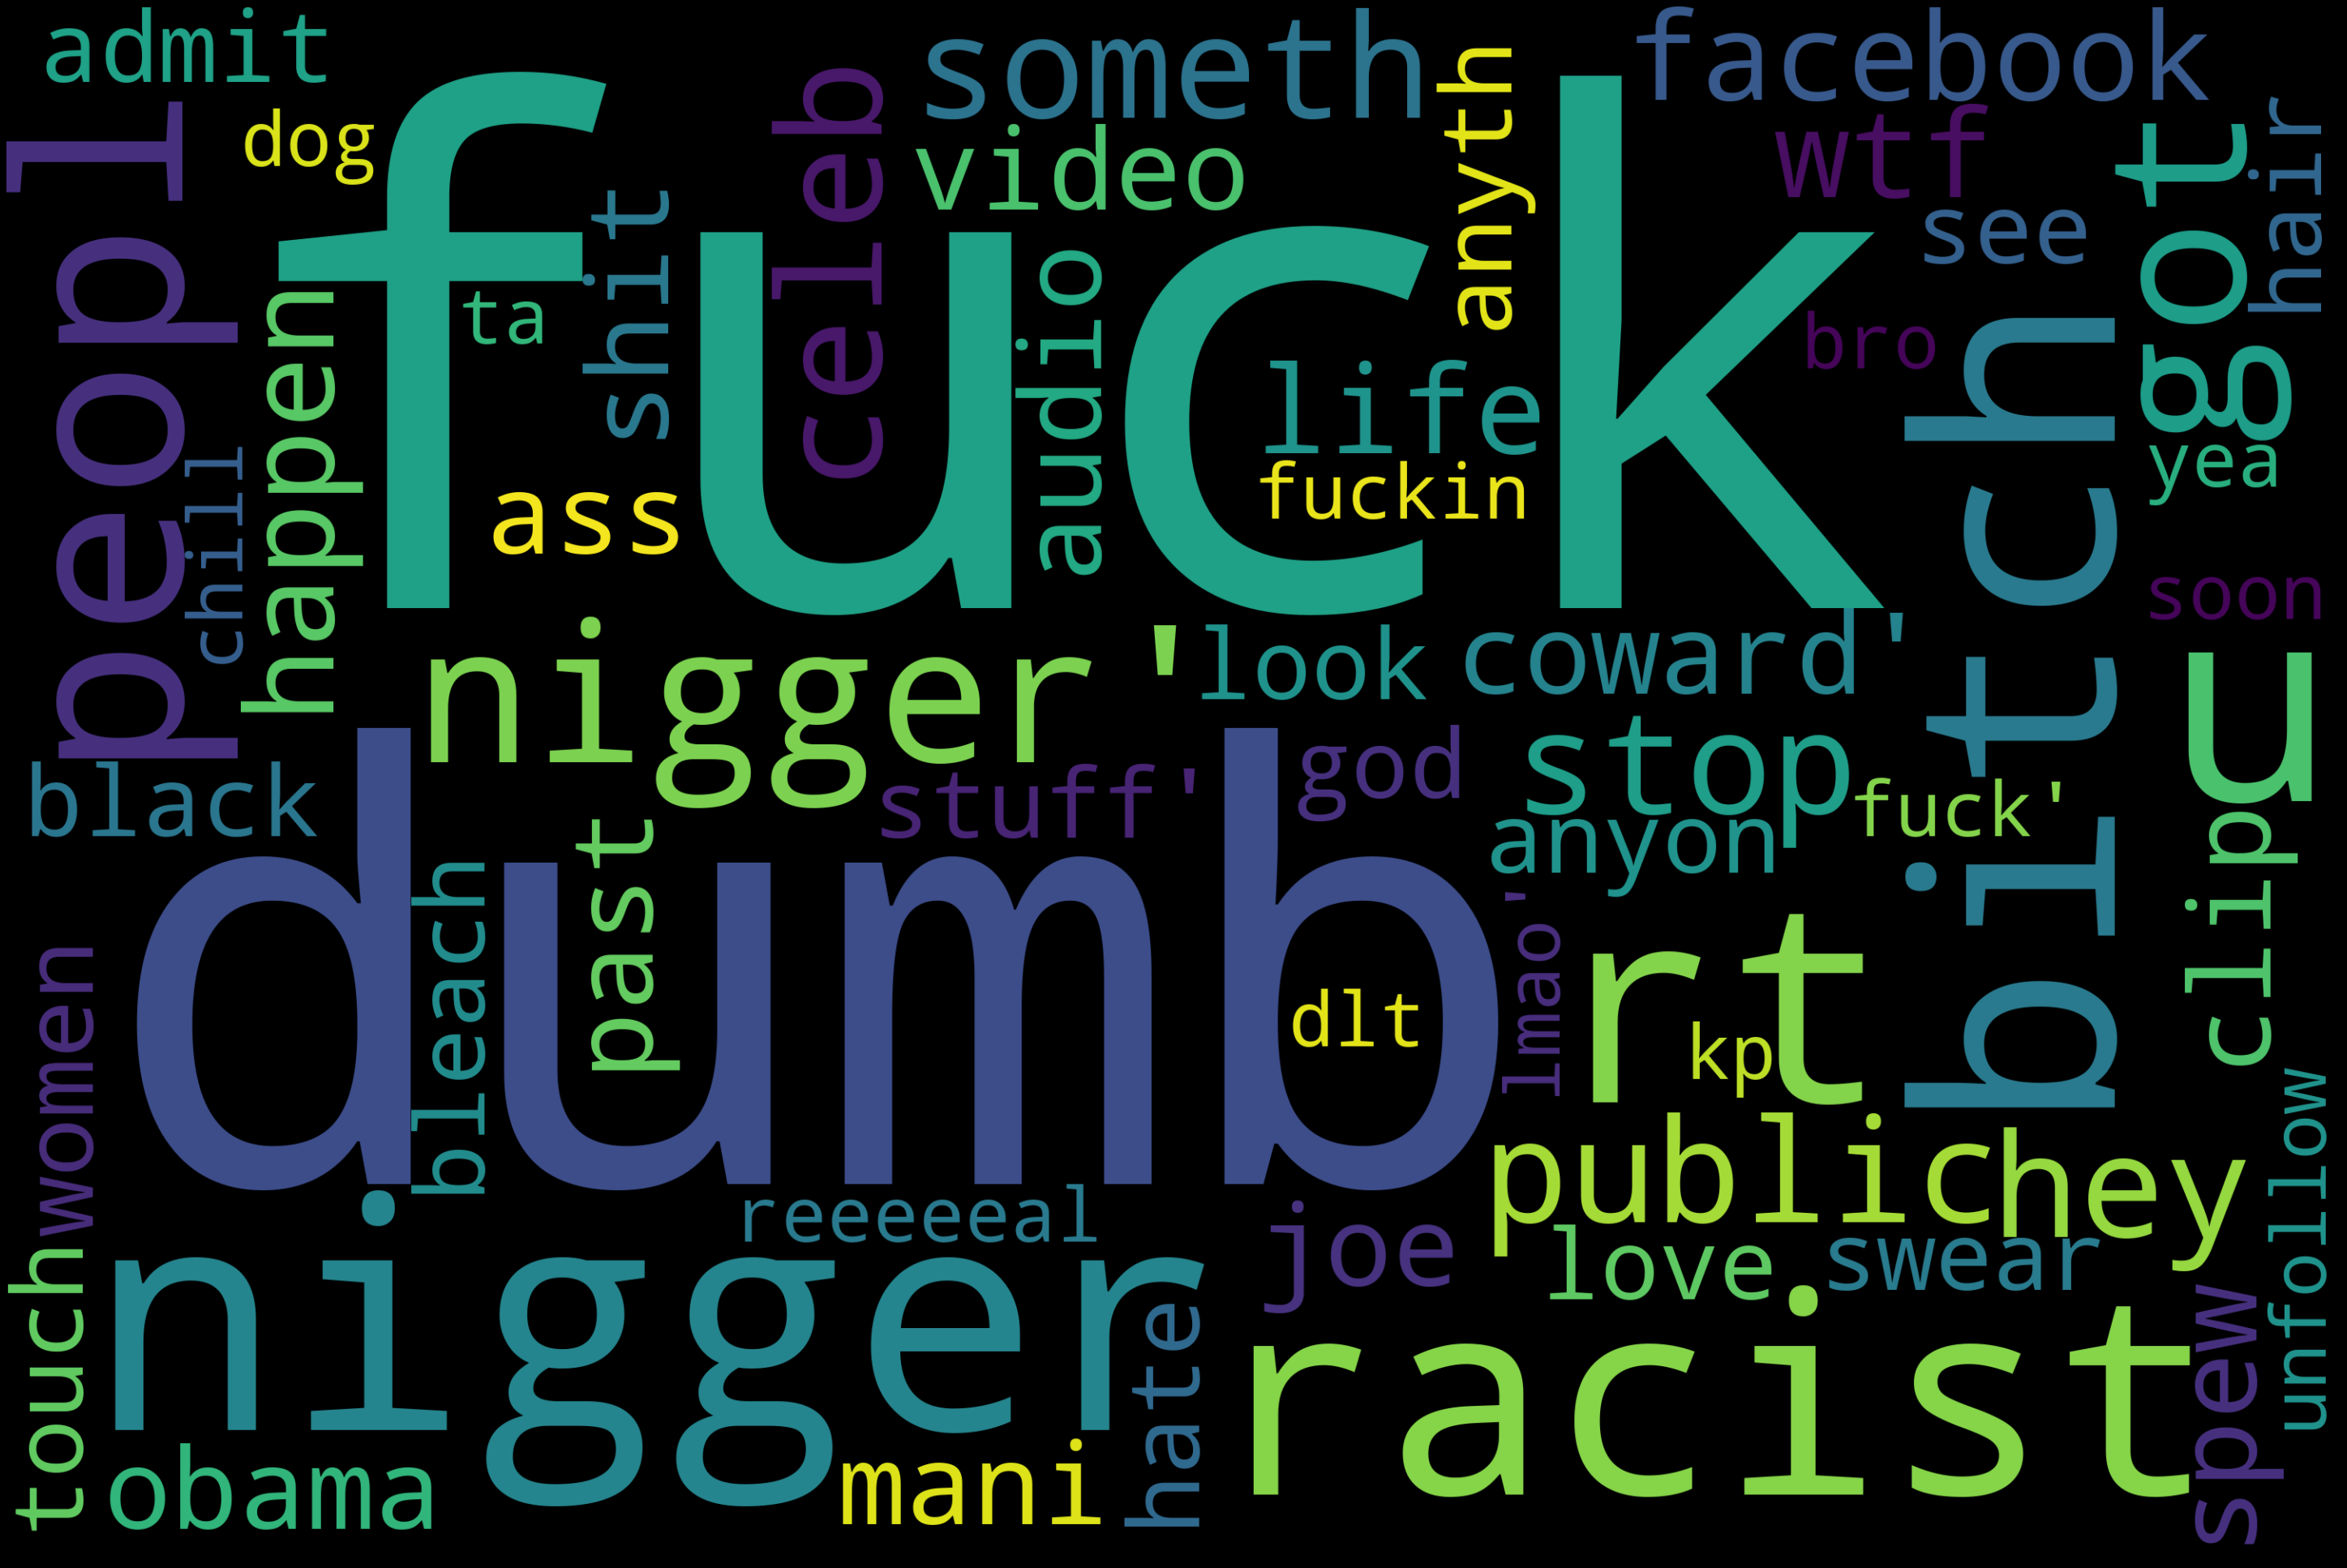

In [25]:
ethin_txt=ethnicity_df['text_clean']
generate_word_cloud(ethin_txt.values)

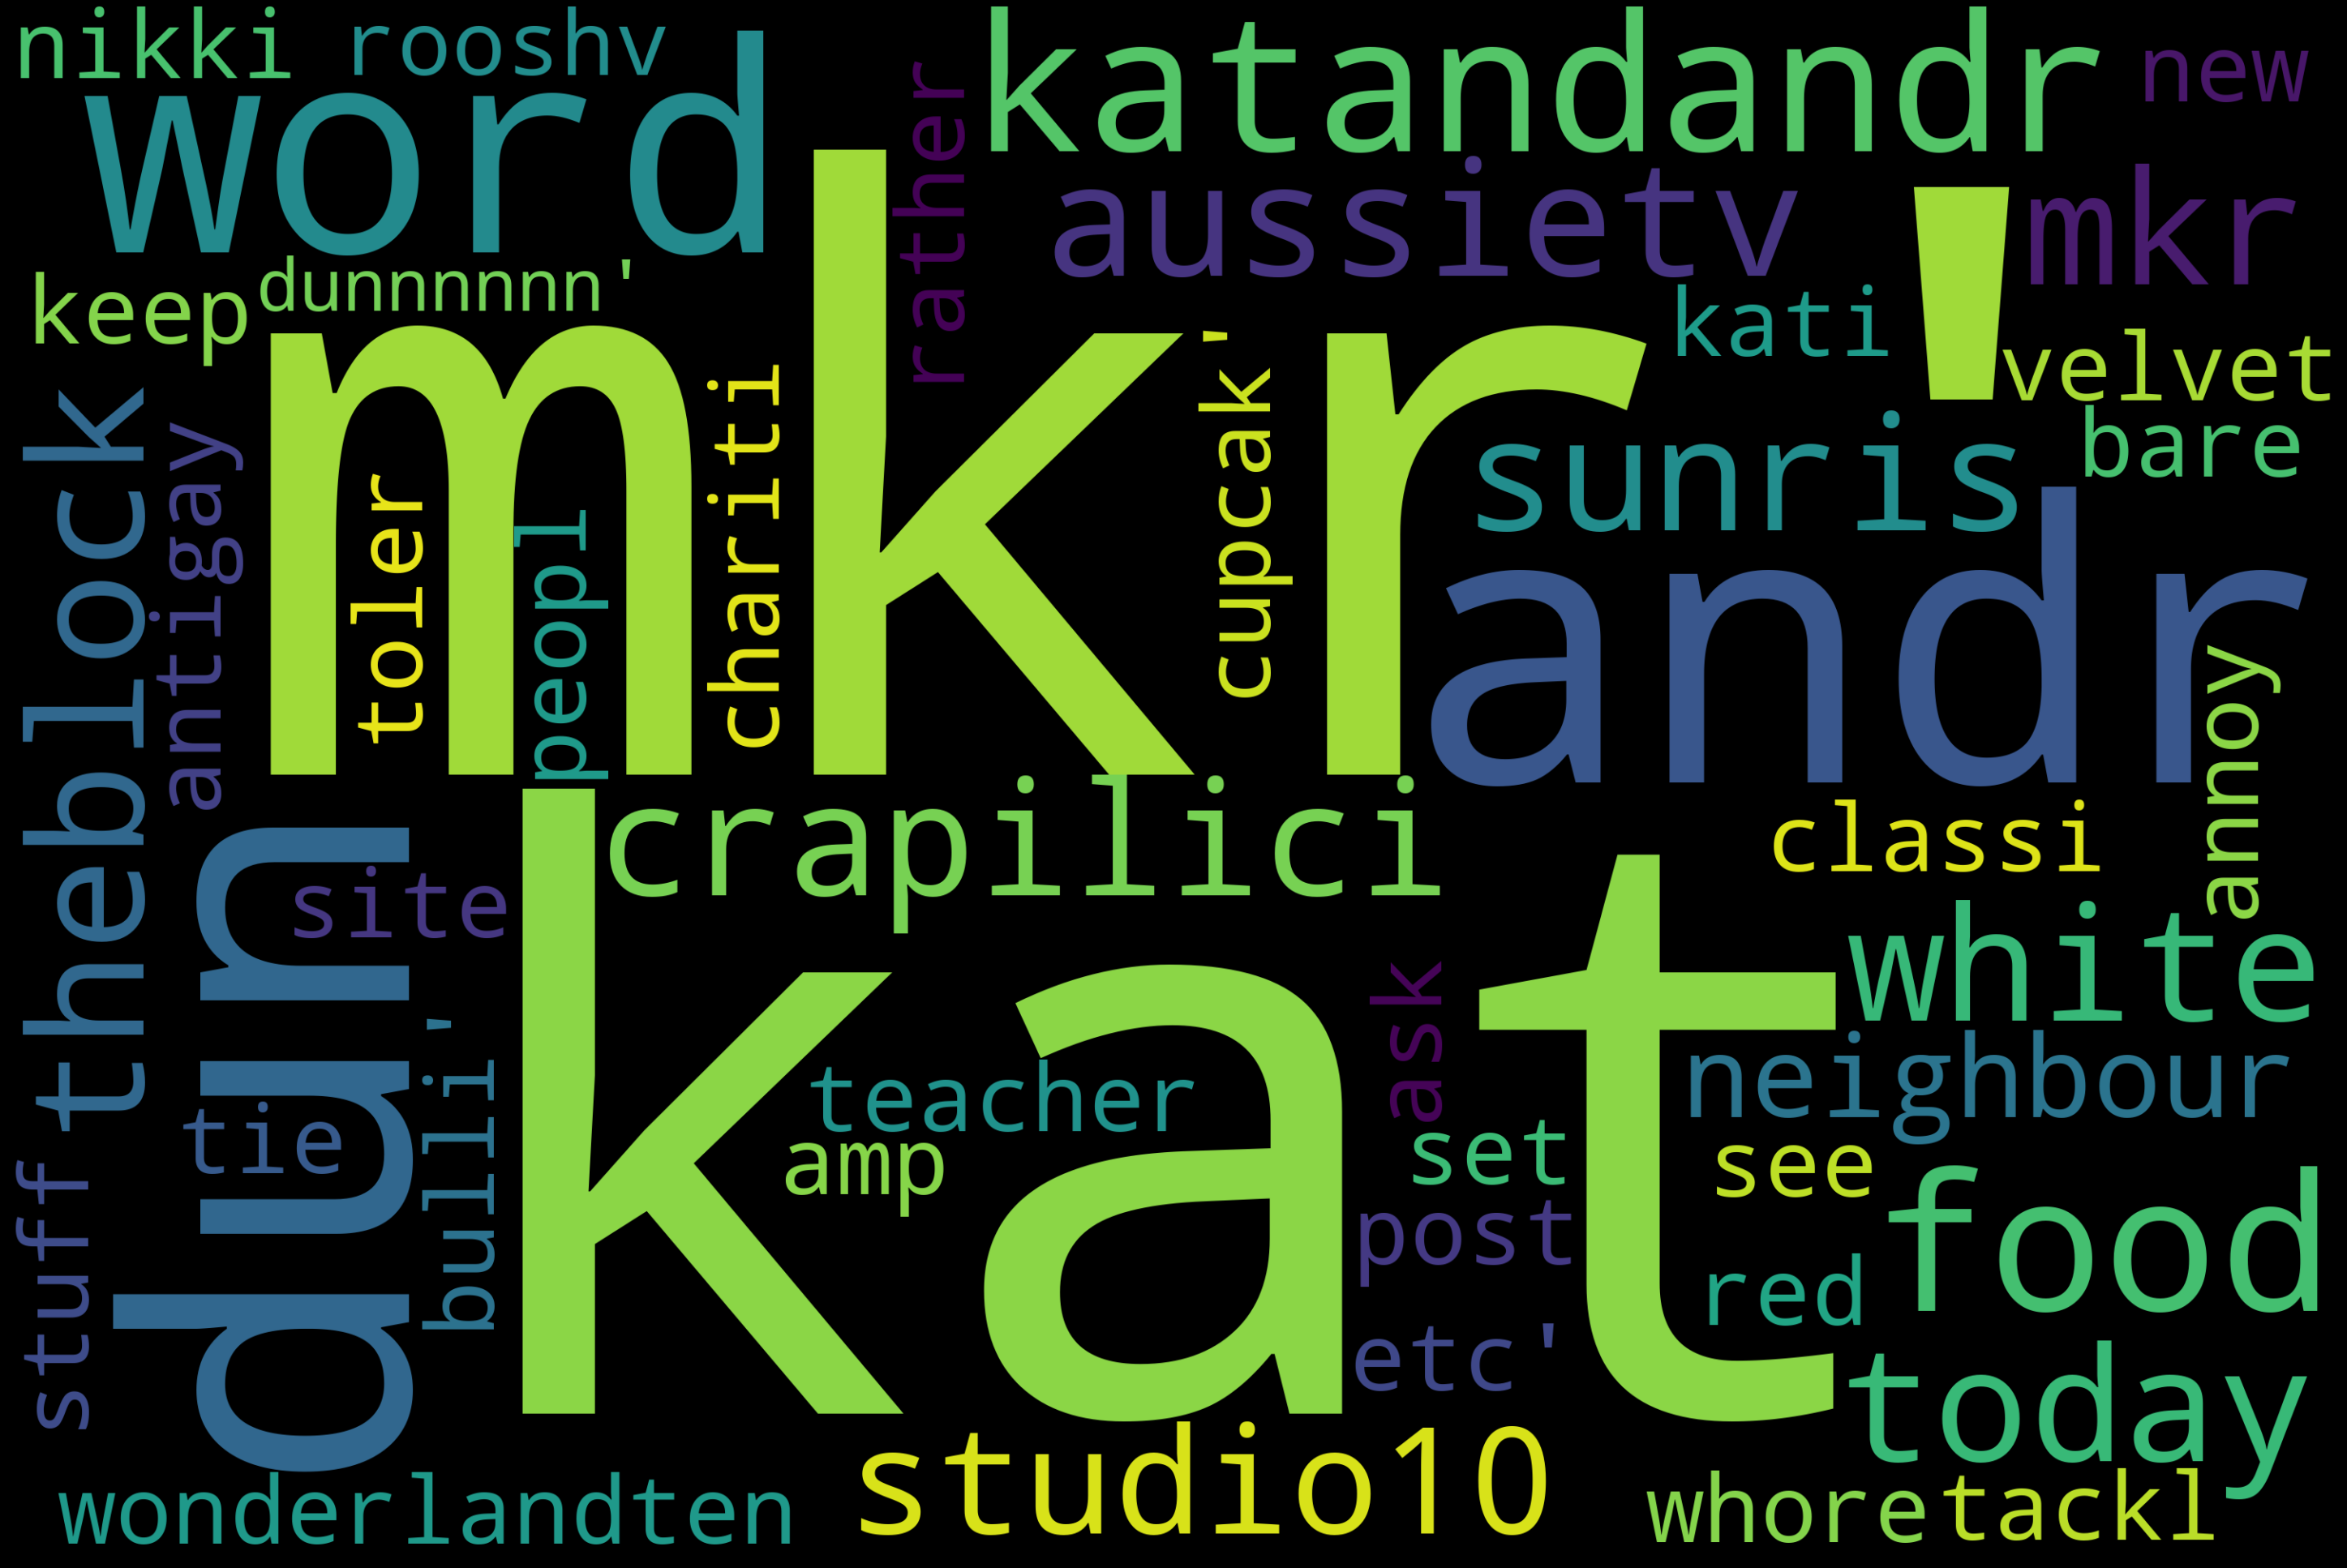

In [26]:
not_cyber_df=data_df[data_df['cyberbullying_type']=="not_cyberbullying"]
nonbully_txt=not_cyber_df['text_clean']
generate_word_cloud(nonbully_txt.values)

In [27]:
ps = PorterStemmer()

def stemming(corpus):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    stemmed_corpus = re.sub('[^a-zA-Z]',' ',corpus)
    
    # Converting all letters to lowercase 
    stemmed_corpus = stemmed_corpus.lower()
    
    # Converting all to a splitted case or a list
    stemmed_corpus = stemmed_corpus.split()
    
    # Applying stemming, so we get the root words wherever possible + remove stopwords as well
    stemmed_corpus = [ps.stem(word) for word in stemmed_corpus] #if not word in stopwords.words('english')]
    
    # Join all the words in final content
    stemmed_corpus = ' '.join(stemmed_corpus)
    return stemmed_corpus

In [28]:
data_df['stemmedtext'] = data_df['text_clean'].apply(stemming)

In [29]:
def tokenizeandstopwords(text):
    tokens = nltk.word_tokenize(text)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    meaningful_words = [w for w in token_words if not w in stop]
    joined_words = ( " ".join(meaningful_words))
    return joined_words

In [30]:
stop = stopwords.words('english')

In [31]:
data_df['text_clean'] = data_df['text_clean'].apply(tokenizeandstopwords)

In [32]:
def basic_clean(text):
#   simple function to clean up the data. All the words that
#   are not designated as a stop word is then lemmatized after
#   encoding and basic regex parsing are performed.
 
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [33]:
words = basic_clean(''.join(str(data_df['text_clean'].tolist())))

In [34]:
#words

In [35]:
len(words)

603716

In [36]:
cvec = CountVectorizer()
word_count=cvec.fit_transform(words)
word_count.shape
print(word_count)

  (0, 32645)	1
  (1, 15680)	1
  (2, 10423)	1
  (3, 6415)	1
  (4, 18917)	1
  (5, 2007)	1
  (6, 32278)	1
  (7, 18917)	1
  (8, 29232)	1
  (9, 29749)	1
  (10, 28303)	1
  (11, 20003)	1
  (12, 32609)	1
  (13, 9191)	1
  (14, 5491)	1
  (15, 32333)	1
  (16, 24300)	1
  (17, 31369)	1
  (18, 6691)	1
  (19, 18358)	1
  (21, 29162)	1
  (22, 12702)	1
  (23, 5952)	1
  (24, 1282)	1
  (25, 1217)	1
  :	:
  (603690, 10804)	1
  (603691, 27380)	1
  (603692, 7971)	1
  (603693, 10771)	1
  (603694, 33038)	1
  (603695, 10771)	1
  (603696, 25146)	1
  (603697, 20229)	1
  (603698, 10771)	1
  (603699, 30874)	1
  (603700, 10771)	1
  (603701, 8407)	1
  (603702, 20229)	1
  (603703, 3934)	1
  (603705, 11789)	1
  (603706, 28573)	1
  (603707, 5210)	1
  (603708, 25146)	1
  (603709, 8025)	1
  (603710, 10771)	1
  (603711, 16203)	1
  (603712, 8407)	1
  (603713, 20229)	1
  (603714, 3210)	1
  (603715, 17121)	1


In [37]:
occ = np.asarray(word_count.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

C:\Users\Rach\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


term  occurrences
4131    bulli        11227
25746  school         9169
10771    fuck         7921
16933    like         6325
20229  nigger         5619
15225    joke         5578
11470    girl         5544
8407     dumb         5341
12988    high         5102
22162   peopl         4903
19521  muslim         4766
24012    rape         4494
11155     gay         4369
25146      rt         4318
4468     call         3980
11346     get         3794
21162     one         3739
13704   idiot         3497
32567   woman         3235
25646     say         3068

In [38]:

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_tbest_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [39]:
# split data into training and testing set
# establish input and output
X = list(data_df['text_clean'])
y = list(data_df['cyberbullying_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Count Vectorization and N-gram analysis

In [40]:
unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:25]

Text(0.5, 0, 'Number of Occurances')

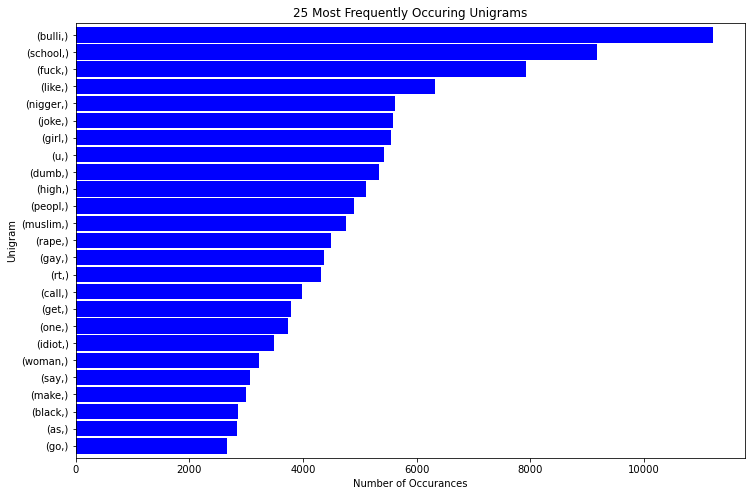

In [41]:
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('Number of Occurances')

In [42]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:25]

Text(0.5, 0, 'Number of Occurances')

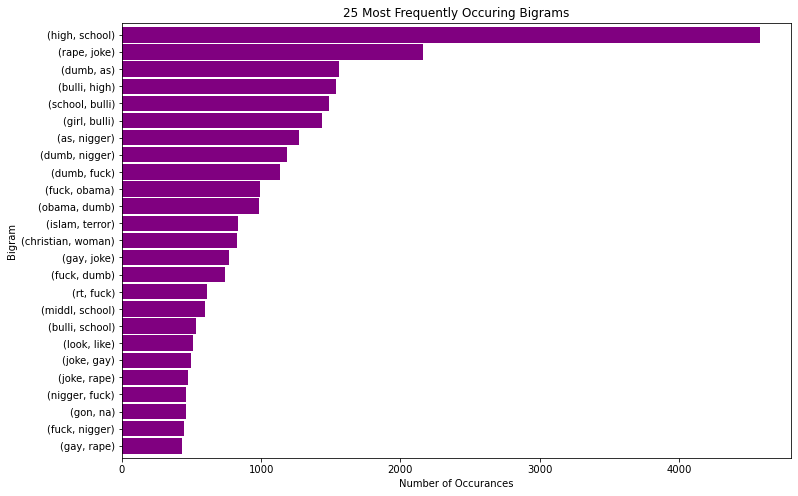

In [43]:
bigrams_series.sort_values().plot.barh(color='purple', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

In [44]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:25]

Text(0.5, 0, 'Number of Occurances')

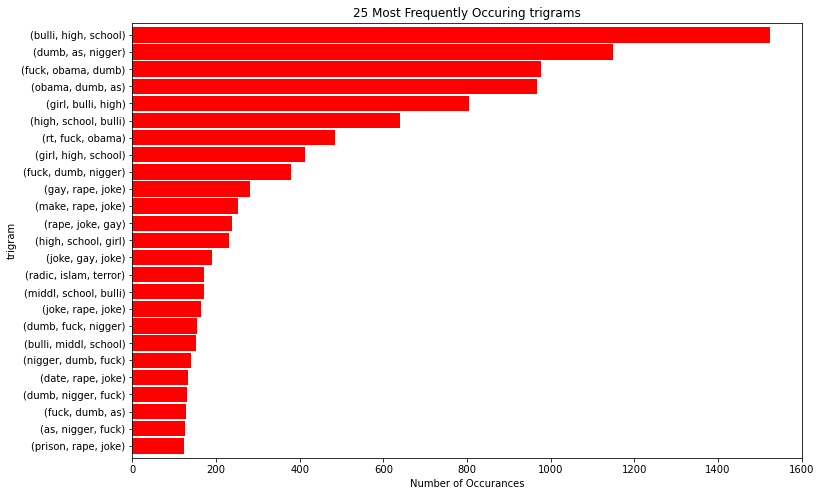

In [45]:
trigrams_series.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring trigrams')
plt.ylabel('trigram')
plt.xlabel('Number of Occurances')

In [46]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [47]:
%%time
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.25%
model is 18.23% less accurate than null accuracy
train and test time: 5.64s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.26%
model is 18.22% less accurate than null accuracy
train and test time: 5.09s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.40s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.65s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.11s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 8.42s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.26s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 5.95s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.45s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.17s
--------------------------------------------------------------------------------
CPU times: total: 1min 51s
Wall time: 1min 3s


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
%%time
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.35%
model is 18.13% less accurate than null accuracy
train and test time: 4.17s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.43%
model is 18.05% less accurate than null accuracy
train and test time: 5.20s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.12s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.61s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.08s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.26s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.61s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.20s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.47s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.28s
--------------------------------------------------------------------------------
CPU times: total: 1min 48s
Wall time: 1min


In [49]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()
#print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
#feature_result_wocsw = nfeature_accuracy_checker(stop_words)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.25%
model is 18.23% less accurate than null accuracy
train and test time: 4.11s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.26%
model is 18.22% less accurate than null accuracy
train and test time: 5.41s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.32s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.05s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.59s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.07s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.29s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.25s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.12s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.24%
model is 18.24% less accurate than null accuracy
train and test time: 6.44s
--------------------------------------------------------------------------------
RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.35%
model is 18.13% less accurate than null accuracy
train and test time: 4.05s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.43%
model is 18.05% less accurate than null accuracy
train and test time: 4.98s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.56s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.22s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.40s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.45s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.47s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.63s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.09s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 6.46s
--------------------------------------------------------------------------------


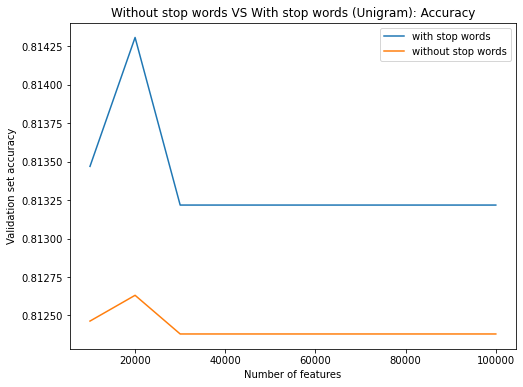

In [50]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
#nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
#plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [51]:
print("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.65%
model is 17.83% less accurate than null accuracy
train and test time: 5.48s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.19%
model is 18.29% less accurate than null accuracy
train and test time: 6.88s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.41%
model is 18.07% less accurate than null accuracy
train and test time: 9.51s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 9.49s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.37%
model is 18.11% less accurate than null accuracy
train and test time: 10.39s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.35%
model is 18.13% less accurate than null accuracy
train and test time: 12.13s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.37%
model is 18.11% less accurate than null accuracy
train and test time: 13.30s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.44%
model is 18.04% less accurate than null accuracy
train and test time: 14.64s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.36%
model is 18.12% less accurate than null accuracy
train and test time: 16.05s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 17.25s
--------------------------------------------------------------------------------
RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.62%
model is 17.86% less accurate than null accuracy
train and test time: 7.24s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.23%
model is 18.25% less accurate than null accuracy
train and test time: 8.35s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.25%
model is 18.23% less accurate than null accuracy
train and test time: 9.70s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.31%
model is 18.17% less accurate than null accuracy
train and test time: 10.91s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.27%
model is 18.21% less accurate than null accuracy
train and test time: 12.75s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.37%
model is 18.11% less accurate than null accuracy
train and test time: 13.90s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.25%
model is 18.23% less accurate than null accuracy
train and test time: 19.39s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.27%
model is 18.21% less accurate than null accuracy
train and test time: 22.49s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 18.39s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.32%
model is 18.16% less accurate than null accuracy
train and test time: 25.34s
--------------------------------------------------------------------------------


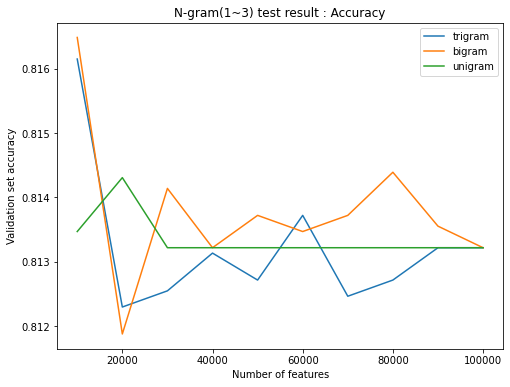

In [52]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [53]:
# #TF-IDF
# transformer = TfidfTransformer()
# transformed_weights = transformer.fit_transform(word_count)
# transformed_weights

In [54]:
# weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
# weights_df = pd.DataFrame({'term': transformer.get_feature_names(), 'weight': weights})
# weights_df.sort_values(by='weight', ascending=False).head(20)

LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.56%
model is 17.92% less accurate than null accuracy
train and test time: 7.37s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.39%
model is 18.09% less accurate than null accuracy
train and test time: 6.71s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 8.91s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 7.29s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 13.78s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 6.98s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 7.72s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 7.27s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 13.73s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.40%
model is 18.08% less accurate than null accuracy
train and test time: 18.61s
--------------------------------------------------------------------------------
LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 82.10%
model is 17.38% less accurate than null accuracy
train and test time: 16.47s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.87%
model is 17.61% less accurate than null accuracy
train and test time: 15.44s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.72%
model is 17.76% less accurate than null accuracy
train and test time: 9.75s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.79%
model is 17.69% less accurate than null accuracy
train and test time: 13.72s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.76%
model is 17.72% less accurate than null accuracy
train and test time: 17.13s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.85%
model is 17.63% less accurate than null accuracy
train and test time: 20.90s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.65%
model is 17.83% less accurate than null accuracy
train and test time: 18.70s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.73%
model is 17.75% less accurate than null accuracy
train and test time: 18.51s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.72%
model is 17.76% less accurate than null accuracy
train and test time: 29.97s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.68%
model is 17.80% less accurate than null accuracy
train and test time: 25.20s
--------------------------------------------------------------------------------
LogisticRegression()


Validation result for 10000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 82.19%
model is 17.29% less accurate than null accuracy
train and test time: 9.27s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.90%
model is 17.58% less accurate than null accuracy
train and test time: 18.26s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.77%
model is 17.71% less accurate than null accuracy
train and test time: 27.41s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.76%
model is 17.72% less accurate than null accuracy
train and test time: 26.76s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.81%
model is 17.67% less accurate than null accuracy
train and test time: 26.07s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.83%
model is 17.65% less accurate than null accuracy
train and test time: 17.33s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.68%
model is 17.80% less accurate than null accuracy
train and test time: 18.83s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.82%
model is 17.66% less accurate than null accuracy
train and test time: 17.68s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.73%
model is 17.75% less accurate than null accuracy
train and test time: 21.74s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\Rach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 99.48%
accuracy score: 81.64%
model is 17.84% less accurate than null accuracy
train and test time: 26.29s
--------------------------------------------------------------------------------


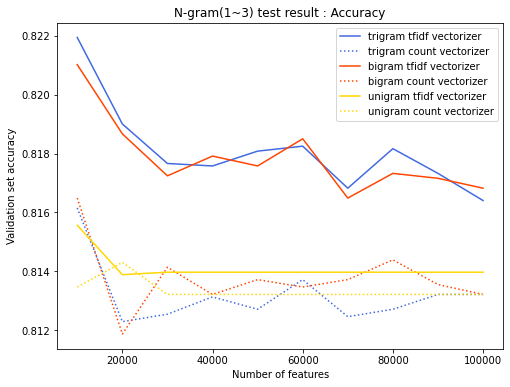

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

## TF-IDF
#### As tf-idf performs better compared to count vectorizer,we will use TF-IDF vectors

In [56]:
data_df["text_clean"].duplicated().sum()

3162

In [57]:
data_df.drop_duplicates("text_clean", inplace=True)

In [58]:
data_df.cyberbullying_type.value_counts()

religion               7941
age                    7881
ethnicity              7730
not_cyberbullying      7616
gender                 7603
other_cyberbullying    5759
Name: cyberbullying_type, dtype: int64

In [59]:
data_df= data_df[data_df.cyberbullying_type != 'other_cyberbullying']

In [60]:
data_df.cyberbullying_type.value_counts()

religion             7941
age                  7881
ethnicity            7730
not_cyberbullying    7616
gender               7603
Name: cyberbullying_type, dtype: int64

In [61]:
text_len = []
for text in data_df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [62]:
data_df['text_len'] = text_len

In [63]:
data_df.sort_values(by=['text_len'], ascending=False)

tweet_text cyberbullying_type  \
44035  You so black and white trying to live like a n...          ethnicity   
45165  @hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...          ethnicity   
33724  ... I don't feel guilty for killing him, I jus...                age   
1317   @EurekAlertAAAS: Researchers push to import to...  not_cyberbullying   
47037  @Purely_Ambition: Sooo mad. RT @TracePeterson ...          ethnicity   
...                                                  ...                ...   
3269                                               Steve  not_cyberbullying   
558                         @root_tim this is my work :)  not_cyberbullying   
6250                                      2. She's crazy  not_cyberbullying   
1146                       Melon https://t.co/hzZj18a4N3  not_cyberbullying   
10                  @Jord_Is_Dead http://t.co/UsQInYW5Gn  not_cyberbullying   

                                              text_clean  \
44035  black white tri live like nigger pahahahaha co...   
45165  fuck obama dumb ass nigger bitch ltthi whore s...   
33724  feel guilti kill feel guilti enjoy torment sin...   
1317   research push import top antibulli program us ...   
47037  sooo mad rt fuck obama dumb nigger go switzerl...   
...                                                  ...   
3269                                               steve   
558                                                 work   
6250                                               crazi   
1146                                               melon   
10                                                         

                                             stemmedtext  text_len  
44035  black white tri live like nigger pahahahaha co...       183  
45165  fuck obama dumb ass nigger bitch ltthi whore s...       157  
33724  feel guilti kill feel guilti enjoy torment sin...       136  
1317   research push import top antibulli program us ...       133  
47037  sooo mad rt fuck obama dumb nigger go switzerl...       124  
...                                                  ...       ...  
3269                                               steve         1  
558                                                 work         1  
6250                                               crazi         1  
1146                                               melon         1  
10                                                               0  

[38771 rows x 5 columns]

In [64]:
data_df = data_df[data_df['text_len'] > 3]
#df = df[df['text_len'] < 100]


In [65]:
data_df

tweet_text cyberbullying_type  \
0      In other words #katandandre, your food was cra...  not_cyberbullying   
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   
...                                                  ...                ...   
47687  Black ppl aren't expected to do anything, depe...          ethnicity   
47688  Turner did not withhold his disappointment. Tu...          ethnicity   
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity   
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity   
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity   

                                              text_clean  \
0                     word katandandr food crapilici mkr   
1      aussietv white mkr theblock today sunris neigh...   
2                         classi whore red velvet cupcak   
3      meh p thank head concern anoth angri dude twitter   
4      isi account pretend kurdish account like islam...   
...                                                  ...   
47687  black ppl expect anyth depend anyth yet free p...   
47688  turner withhold turner call court abomin concl...   
47689  swear god dumb nigger bitch got bleach hair re...   
47690  yea fuck rt nigger fuck unfollow fuck dumb nigger   
47691  bro u got ta chill rt dog fuck kp dumb nigger ...   

                                             stemmedtext  text_len  
0                     word katandandr food crapilici mkr         5  
1      aussietv white mkr theblock today sunri studio...         9  
2                         classi whore red velvet cupcak         5  
3      meh p thank head concern anoth angri dude twitter         9  
4      isi account pretend kurdish account like islam...         8  
...                                                  ...       ...  
47687  black ppl expect anyth depend anyth yet free p...        21  
47688  turner withhold turner call court abomin concl...        28  
47689  swear god dumb nigger bitch got bleach hair re...        13  
47690  yea fuck rt your nigger fuck unfollow fuck dum...         9  
47691  bro u got ta chill rt dog fuck kp dumb nigger ...        13  

[37026 rows x 5 columns]

In [121]:
# establish input and output
X = list(data_df['text_clean'])
y = list(data_df['cyberbullying_type'])

In [122]:
# split data into training and testing set
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [123]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

In [124]:
# first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 
# # place tf-idf values in a pandas data frame 
# df = pd.DataFrame(first_vector_tfidfv# get the first vector out (for the first document) 
# ectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) df.sort_values(by=["tfidf"],ascending=False)

In [125]:
feature_names = vectorizer.get_feature_names()

C:\Users\Rach\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [126]:
len(feature_names)

26605

In [152]:
from sklearn.feature_selection import SelectPercentile,f_classif
selector=SelectPercentile(f_classif,percentile=10)

In [153]:
selector.fit(tf_x_train,y_train)

SelectPercentile()

In [129]:
# tf_x_train=selector.transform(tf_x_train).toarray()
# tf_x_test=selector.transform(tf_x_test).toarray()

In [151]:
tf_x_train

<27769x26605 sparse matrix of type '<class 'numpy.float64'>'
	with 372955 stored elements in Compressed Sparse Row format>

### SVC model

In [131]:

clf = LinearSVC(random_state=0)

In [132]:
clf.fit(tf_x_train,y_train)

LinearSVC(random_state=0)

In [133]:
y_test_pred=clf.predict(tf_x_test)

In [134]:

report=classification_report(y_test, y_test_pred,output_dict=True)

In [135]:
report

{'age': {'precision': 0.9379004435682602,
  'recall': 0.9789094650205762,
  'f1-score': 0.9579662723382835,
  'support': 1944},
 'ethnicity': {'precision': 0.9802802283341983,
  'recall': 0.9869383490073145,
  'f1-score': 0.9835980213486071,
  'support': 1914},
 'gender': {'precision': 0.9347198151357596,
  'recall': 0.8841530054644808,
  'f1-score': 0.9087335018253299,
  'support': 1830},
 'not_cyberbullying': {'precision': 0.8103879849812266,
  'recall': 0.8053482587064676,
  'f1-score': 0.8078602620087336,
  'support': 1608},
 'religion': {'precision': 0.9467545638945233,
  'recall': 0.9520652728199898,
  'f1-score': 0.9494024917365878,
  'support': 1961},
 'accuracy': 0.9260019444744517,
 'macro avg': {'precision': 0.9220086071827935,
  'recall': 0.9214828702037657,
  'f1-score': 0.9215121098515084,
  'support': 9257},
 'weighted avg': {'precision': 0.9257601448281049,
  'recall': 0.9260019444744517,
  'f1-score': 0.9256446950667282,
  'support': 9257}}

In [136]:
print(classification_report(y_test, y_test_pred))

                   precision    recall  f1-score   support

              age       0.94      0.98      0.96      1944
        ethnicity       0.98      0.99      0.98      1914
           gender       0.93      0.88      0.91      1830
not_cyberbullying       0.81      0.81      0.81      1608
         religion       0.95      0.95      0.95      1961

         accuracy                           0.93      9257
        macro avg       0.92      0.92      0.92      9257
     weighted avg       0.93      0.93      0.93      9257



## Random forest

In [137]:
random_forest=RandomForestClassifier(n_estimators=200)
rf_model=random_forest.fit(tf_x_train,y_train)

In [138]:
y_test_pred_rf=rf_model.predict(tf_x_test)

In [139]:
print(classification_report(y_test, y_test_pred_rf))

                   precision    recall  f1-score   support

              age       0.98      0.98      0.98      1944
        ethnicity       0.99      0.99      0.99      1914
           gender       0.95      0.88      0.91      1830
not_cyberbullying       0.82      0.88      0.85      1608
         religion       0.96      0.97      0.96      1961

         accuracy                           0.94      9257
        macro avg       0.94      0.94      0.94      9257
     weighted avg       0.94      0.94      0.94      9257



In [140]:
# i=0
# for name, importance in zip(feature_names, rf_model.feature_importances_):
            
#             print(name, "=", importance)
            

In [141]:
important_features_dict = {}
for idx, val in zip(feature_names, rf_model.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'30 most important features: {important_features_list[:30]}') 


30 most important features: ['school', 'bulli', 'nigger', 'dumb', 'high', 'muslim', 'fuck', 'joke', 'gay', 'rape', 'idiot', 'girl', 'islam', 'christian', 'mkr', 'black', 'sexist', 'bitch', 'ass', 'femal', 'rt', 'radic', 'terrorist', 'white', 'call', 'terror', 'ur', 'negro', 'obama', 'woman']


In [142]:
feature_importances_list = pd.DataFrame(rf_model.feature_importances_,index =feature_names, columns=['importance']).sort_values('importance', ascending=False)

In [161]:
print(feature_importances_list[:30])

           importance
school       0.061205
bulli        0.050918
nigger       0.038585
dumb         0.036127
high         0.035792
muslim       0.030991
fuck         0.030169
joke         0.029421
gay          0.024860
rape         0.024522
idiot        0.024015
girl         0.017951
islam        0.015626
christian    0.012207
mkr          0.010808
black        0.009476
sexist       0.009110
bitch        0.007788
ass          0.007711
femal        0.007416
rt           0.007212
radic        0.006437
terrorist    0.006404
white        0.006125
call         0.006049
terror       0.005759
ur           0.005177
negro        0.005143
obama        0.005122
woman        0.005039


### Adaboost classifier

In [95]:
ada_boost=AdaBoostClassifier(n_estimators=50, learning_rate=1)

In [96]:
model_ada=ada_boost.fit(tf_x_train,y_train)

In [97]:
y_test_pred_ada=model_ada.predict(tf_x_test)

In [98]:
print(classification_report(y_test, y_test_pred_ada))

                   precision    recall  f1-score   support

              age       0.96      0.98      0.97      1944
        ethnicity       0.97      0.97      0.97      1914
           gender       0.90      0.82      0.86      1830
not_cyberbullying       0.76      0.79      0.77      1608
         religion       0.91      0.94      0.93      1961

         accuracy                           0.91      9257
        macro avg       0.90      0.90      0.90      9257
     weighted avg       0.91      0.91      0.91      9257



In [87]:
important_features_dict_ada = {}
for idx, val in zip(feature_names, model_ada.feature_importances_):
    important_features_dict_ada[idx] = val

important_features_list_ada = sorted(important_features_dict_ada,
                                 key=important_features_dict_ada.get,
                                 reverse=True)

print(f'30 most important features: {important_features_list_ada[:30]}') 

30 most important features: ['bulli', 'arab', 'asian', 'ass', 'bad', 'birthday', 'bitch', 'black', 'call', 'christian', 'color', 'coon', 'dumb', 'femal', 'feminazi', 'ff', 'first', 'fuck', 'gay', 'idiot', 'incid', 'islam', 'joke', 'lilnigga', 'mkr', 'moham', 'muslim', 'negro', 'nigga', 'nigganigg']


In [88]:
set(important_features_list[:30]) & set(important_features_list_ada[:30])

{'ass',
 'bitch',
 'black',
 'bulli',
 'call',
 'christian',
 'dumb',
 'femal',
 'fuck',
 'gay',
 'idiot',
 'islam',
 'joke',
 'mkr',
 'muslim',
 'negro'}

## Hyperparameter tuning on Random forest model

## 1. randomized search on random forest model

In [135]:
from sklearn.model_selection import RandomizedSearchCV

In [136]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [232]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
tuning_model = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid,
                                  n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(train_features, train_labels)

In [233]:
tuning_model.fit(tf_x_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=200),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [148]:
tuning_model.best_params_

In [235]:
tuning_model.best_score_

0.9181819845459751

In [236]:
tuned_hyper_model= RandomForestClassifier(n_estimators=1800,min_samples_split=10,
 min_samples_leaf=2,
 max_features='auto',
 max_depth=110,
 bootstrap=False)

In [237]:
tuned_hyper_model.fit(tf_x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=110, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=1800)

In [238]:
tuned_pred=tuned_hyper_model.predict(tf_x_test)

In [239]:
print(classification_report(y_test, tuned_pred))

                   precision    recall  f1-score   support

              age       0.96      0.99      0.98      1944
        ethnicity       0.98      0.99      0.99      1914
           gender       0.96      0.86      0.91      1830
not_cyberbullying       0.81      0.86      0.84      1608
         religion       0.95      0.97      0.96      1961

         accuracy                           0.94      9257
        macro avg       0.93      0.93      0.93      9257
     weighted avg       0.94      0.94      0.94      9257



## 2. randomized search on random forest model with reduced n_estimators

In [364]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [381]:
tuning_model_new=RandomizedSearchCV(estimator = random_forest,param_distributions=random_grid,n_iter = 10,cv=3,verbose=2)

In [383]:
tuning_model_new.fit(tf_x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=238; total time=  37.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=238; total time=  35.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=238; total time=  36.2s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time= 1.4min
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time= 1.4min
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time= 1.4min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimato

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=200),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 205, 211, 216,
                                                         222, 227, 233, 238,
                                                         244, 250]},
                   verbose=2)

In [384]:
tuning_model_new.best_params_

{'n_estimators': 205,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [149]:
# tuned_hyper_model_new= RandomForestClassifier(n_estimators=5000,min_samples_split=10,
#  min_samples_leaf=2,
#  max_features='auto',
#  max_depth=300,
#  bootstrap=False)
tuned_hyper_model_new= RandomForestClassifier(n_estimators=205,min_samples_split=10,
 min_samples_leaf=1,
 max_features='sqrt',
 max_depth=90,
 bootstrap=False)

In [150]:
tuned_hyper_model_new.fit(tf_x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_split=10, n_estimators=205)

In [151]:
tuned_pred_new=tuned_hyper_model_new.predict(tf_x_test)

In [152]:
print(classification_report(y_test, tuned_pred_new))

                   precision    recall  f1-score   support

              age       0.96      0.99      0.98      1944
        ethnicity       0.99      0.99      0.99      1914
           gender       0.96      0.86      0.91      1830
not_cyberbullying       0.82      0.87      0.84      1608
         religion       0.95      0.97      0.96      1961

         accuracy                           0.94      9257
        macro avg       0.94      0.94      0.94      9257
     weighted avg       0.94      0.94      0.94      9257



## 3. min sample leaves,split increased

In [153]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,20]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [154]:
tuning_model_new=RandomizedSearchCV(estimator = random_forest,param_distributions=random_grid,n_iter = 10,cv=4,verbose=2)

In [155]:
tuning_model_new.fit(tf_x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 1.2min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 1.1min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 1.1min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time= 2.4min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; total time= 2.4min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=20, n_estimators=600; 

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(n_estimators=200),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 20],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [156]:
tuning_model_new.best_params_

{'n_estimators': 1200,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [157]:
tuned_hyper_model_new= RandomForestClassifier(n_estimators=1200,min_samples_split=20,
 min_samples_leaf=1,
 max_features='sqrt',
 max_depth=90,
 bootstrap=False)

In [158]:
tuned_hyper_model_new.fit(tf_x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_split=20, n_estimators=1200)

In [159]:
tuned_pred_new=tuned_hyper_model_new.predict(tf_x_test)

In [160]:
print(classification_report(y_test, tuned_pred_new))

                   precision    recall  f1-score   support

              age       0.97      0.99      0.98      1944
        ethnicity       0.99      0.99      0.99      1914
           gender       0.96      0.86      0.91      1830
not_cyberbullying       0.81      0.87      0.84      1608
         religion       0.95      0.97      0.96      1961

         accuracy                           0.94      9257
        macro avg       0.94      0.94      0.94      9257
     weighted avg       0.94      0.94      0.94      9257



## The accuracy does not increase after hyperparameter tuning

## word2vec

In [137]:
# Create vocabulary with training texts.
# By default, all punctuation is removed
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)

In [138]:
from gensim.models import Word2Vec

class MeanEmbeddingVectorizer():
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])
    
    def fit(self, X, y):
        return self

data_df["tokenized"] = [tokenizer.tokenize(i) for i in data_df['text_clean']]
model = Word2Vec(data_df["tokenized"], min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 
modelw = MeanEmbeddingVectorizer(w2v)

In [139]:
data_df["cyberbullying_type_code"] = data_df.cyberbullying_type.astype('category').cat.codes
data_df["cyberbullying_type_code"].unique()

array([3, 2, 4, 0, 1], dtype=int8)

In [140]:
col1=data_df["cyberbullying_type_code"].unique()
col2=data_df["cyberbullying_type"].unique()
print(col1,col2)

[3 2 4 0 1] ['not_cyberbullying' 'gender' 'religion' 'age' 'ethnicity']


In [141]:
X_train, X_test, y_train, y_test = train_test_split(data_df["tokenized"],data_df["cyberbullying_type_code"],test_size=0.25,shuffle=True, stratify=data_df["cyberbullying_type"], random_state=32)

# Convert train and test sets to vectors
X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)

## SVC on word2vec

In [142]:
clf.fit(X_train_vectors_w2v,y_train)

C:\Users\Rach\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=0)

In [143]:
y_test_pred_w2v=clf.predict(X_test_vectors_w2v)

In [144]:
report_svc_w2v=classification_report(y_test, y_test_pred_w2v,output_dict=True)

In [145]:
report_svc_w2v

{'0': {'precision': 0.9061302681992337,
  'recall': 0.966785896780787,
  'f1-score': 0.9354758961681087,
  'support': 1957},
 '1': {'precision': 0.9221041982802226,
  'recall': 0.9475051975051975,
  'f1-score': 0.9346321456036915,
  'support': 1924},
 '2': {'precision': 0.9234726688102894,
  'recall': 0.7864184008762322,
  'f1-score': 0.849452824608104,
  'support': 1826},
 '3': {'precision': 0.6954128440366972,
  'recall': 0.720532319391635,
  'f1-score': 0.707749766573296,
  'support': 1578},
 '4': {'precision': 0.9170829170829171,
  'recall': 0.9310344827586207,
  'f1-score': 0.9240060392551585,
  'support': 1972},
 'accuracy': 0.8776061358971589,
 'macro avg': {'precision': 0.872840579281872,
  'recall': 0.8704552594624945,
  'f1-score': 0.8702633344416718,
  'support': 9257},
 'weighted avg': {'precision': 0.8792843778742636,
  'recall': 0.8776061358971589,
  'f1-score': 0.8770690802355755,
  'support': 9257}}

In [146]:
print(classification_report(y_test, y_test_pred_w2v))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1957
           1       0.92      0.95      0.93      1924
           2       0.92      0.79      0.85      1826
           3       0.70      0.72      0.71      1578
           4       0.92      0.93      0.92      1972

    accuracy                           0.88      9257
   macro avg       0.87      0.87      0.87      9257
weighted avg       0.88      0.88      0.88      9257



## Random forest with word2vec

In [147]:
random_forest=RandomForestClassifier(n_estimators=200)
rf_model_w2v=random_forest.fit(X_train_vectors_w2v,y_train)

In [148]:
y_test_pred_rf_w2v=rf_model_w2v.predict(X_test_vectors_w2v)

In [149]:
print(classification_report(y_test, y_test_pred_rf_w2v))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1957
           1       0.92      0.94      0.93      1924
           2       0.91      0.78      0.84      1826
           3       0.70      0.76      0.73      1578
           4       0.89      0.92      0.91      1972

    accuracy                           0.88      9257
   macro avg       0.88      0.87      0.87      9257
weighted avg       0.88      0.88      0.88      9257



## Adaboost with word2vec

In [150]:
ada_boost=AdaBoostClassifier(n_estimators=50, learning_rate=1)

In [151]:
model_ada_w2v=ada_boost.fit(X_train_vectors_w2v,y_train)

In [152]:
y_test_pred_ada_w2v=model_ada_w2v.predict(X_test_vectors_w2v)

In [153]:
print(classification_report(y_test, y_test_pred_ada_w2v))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1957
           1       0.83      0.75      0.79      1924
           2       0.73      0.66      0.70      1826
           3       0.66      0.62      0.64      1578
           4       0.75      0.87      0.81      1972

    accuracy                           0.78      9257
   macro avg       0.77      0.77      0.77      9257
weighted avg       0.78      0.78      0.77      9257

